In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir("../../DATA/H3k4me3/")

In [3]:
# gene_mat = pd.read_csv("GSM6753045_MouseBrain_20um_100barcodes_H3K27ac_matrix.tsv", sep="\t", index_col=0)
# rna = sc.AnnData(X=gene_mat.transpose())
# spatial = pd.read_csv("./MouseBrain_20um_100barcodes_H3K27ac_spatial/tissue_positions_list.csv",index_col=0, header=None)
# spatial = spatial.reindex(list(rna.obs_names))
# spatial.columns = ["in_tissue","row","col","imgrow","imgcol"]
# rna.obsm["spatial"] = np.array(spatial[["imgrow","imgcol"]])
# def exchCoor(adata):
#     spatial = pd.DataFrame(adata.obsm["spatial"])
#     spatial.columns = ["x","y"]
#     spatial["x"] = [-1*i for i in list(spatial["x"])]
#     # spatial["y"] = [-1*i for i in list(spatial["y"])]

#     new_spatial = np.array(spatial[["x","y"]])
#     adata.obsm["spatial"] = new_spatial
# exchCoor(rna)
# rna.write("rna.h5ad")

In [4]:
# rna = sc.read_h5ad("rna.h5ad")

In [5]:
# atac = sc.read_h5ad("peakMat.h5ad")
# atac.obs_names = [i.split("-")[0] for i in list(atac.obs_names)]

In [6]:
# comm_obs = list(set(rna.obs_names) & set(atac.obs_names))

In [7]:
# rna = rna[comm_obs,]
# atac = atac[comm_obs,]
# atac.obsm["spatial"] = rna.obsm["spatial"]

In [8]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../../main/")
import networkx as nx
import scanpy as sc
from switch import SWITCH, preprocess
from itertools import chain

In [9]:
# rna = sc.read_h5ad("rna.h5ad")
# atac = sc.read_h5ad("peakMat.h5ad")

In [10]:
# atac.obs_names = [i.split("-")[0] for i in list(atac.obs_names)]
# comm_cell = list(set(rna.obs_names) & set(atac.obs_names))
# atac = atac[comm_cell]
# rna = rna[comm_cell]
# atac.obsm["spatial"] = rna.obsm["spatial"]
# # atac

In [11]:
# preprocess.get_gene_annotation(rna, 
#                     gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
#                     gtf_by="gene_name",
#                     drop_na=True
# )

In [12]:
# rna.layers["counts"] = rna.X.copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=3000, flavor="seurat_v3",layer="counts")

In [13]:
# split = atac.var_names.str.split(r"[:-]")
# atac.var["chrom"] = split.map(lambda x: x[0])
# atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
# atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# ## print(i.var)

In [14]:
# print(atac.shape[1])
# sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
# print(atac.shape[1])

In [15]:
# guidance = preprocess.rna_anchored_guidance_graph(rna, atac, signs=[-1])
# len(atac.var[atac.var["highly_variable"]==True])

In [16]:
# guidance_hvf = guidance.subgraph(chain(
#    rna.var.query("highly_variable").index,
#    atac.var.query("highly_variable").index
# )).copy()
# nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [17]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")

In [18]:
atac = sc.read_h5ad("atac-pp.h5ad")
rna = sc.read_h5ad("rna-pp.h5ad")
# guidance = nx.read_graphml("guidance.graphml.gz")
guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

In [19]:
# sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.02)
len(atac.var[atac.var["highly_variable"]==True])

9440

In [20]:
preprocess.config_data(
    rna, "NB", use_highly_variable=True,
    use_spatial=True,
    use_layer="counts",
    use_obs_names =False
)
preprocess.config_data(
    atac, "POIS", use_highly_variable=True, 
    use_spatial=True,
    use_obs_names=False
)

In [21]:
guidance_hvf = guidance_hvf.subgraph(chain(
  rna.var.query("highly_variable").index,
  atac.var.query("highly_variable").index
)).copy()

In [22]:
preprocess.Cal_Spatial_Net(rna, rad_cutoff=55, model="Radius")
preprocess.Cal_Spatial_Net(atac, rad_cutoff=55, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 111738 edges, 9542 spots.
11.7101 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 111738 edges, 9542 spots.
11.7101 neighbors per spot on average.


In [23]:
model = SWITCH(adatas={"rna": rna, "atac": atac}, vertices=sorted(guidance_hvf.nodes), h_depth_dsc=2)

- INFO - Set random seed to 0
- DEBUG - Use raw feature for the 'rna' dataset.
- DEBUG - Set 1 GAT conv layer for 'rna' dataset.
- DEBUG - Use NB distribution for the 'rna' dataset.
- DEBUG - Use raw feature for the 'atac' dataset.
- DEBUG - Set 1 GAT conv layer for 'atac' dataset.
- DEBUG - Use POIS distribution for the 'atac' dataset.
- DEBUG - Set 2 layers for the discriminator
- DEBUG - Use log normalize for the 'rna' dataset.
- DEBUG - Use log normalize for the 'atac' dataset.
- INFO - GPU available: True, used device: GPU 1


In [24]:
model.compile()

In [25]:
model.pretrain(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, 
             max_epochs=2000, dsc_k=4, early_stop=False, warmup=True)

- INFO - Prepare data for training.
- DEBUG - Set `dsc_k` = 4 for pretrain.
- DEBUG - Set `max_epochs` = 2000 for pretrain.
- INFO - Pretraining with full batch.
- INFO - Epoch 1 : dsc_loss=0.515, gen_loss=0.564
- INFO - Epoch 2 : dsc_loss=0.653, gen_loss=0.491
- INFO - Epoch 3 : dsc_loss=0.509, gen_loss=0.474
- INFO - Epoch 4 : dsc_loss=0.614, gen_loss=0.453
- INFO - Epoch 5 : dsc_loss=0.696, gen_loss=0.442
- INFO - Epoch 6 : dsc_loss=0.663, gen_loss=0.43
- INFO - Epoch 7 : dsc_loss=0.635, gen_loss=0.425
- INFO - Epoch 8 : dsc_loss=0.688, gen_loss=0.42
- INFO - Epoch 9 : dsc_loss=0.651, gen_loss=0.417
- INFO - Epoch 10 : dsc_loss=0.679, gen_loss=0.416
- INFO - Epoch 11 : dsc_loss=0.685, gen_loss=0.41
- INFO - Epoch 12 : dsc_loss=0.692, gen_loss=0.408
- INFO - Epoch 13 : dsc_loss=0.688, gen_loss=0.407
- INFO - Epoch 14 : dsc_loss=0.691, gen_loss=0.406
- INFO - Epoch 15 : dsc_loss=0.692, gen_loss=0.405
- INFO - Epoch 16 : dsc_loss=0.692, gen_loss=0.405
- INFO - Epoch 17 : dsc_loss=0.691

In [26]:
# model.save("pretrain_model_11n_2dsc_test.pth", overwrite=True)

In [27]:
# rep9/1500
# rep16/1000

In [28]:
# model.load("pretrain_model_11n_2dsc_test.pth")

In [29]:
# model._trainer.reset_lr(lr=2e-4, TTUR=.5)

In [30]:
model.train(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=1000, dsc_k=8, warmup=True)#,mini_batch=True, iteration=1)

- DEBUG - Set `dsc_k` = 8 for training.
- DEBUG - Set `max_epochs` = 1000 for training.
- INFO - Training with full batch.
- INFO - Epoch 1 : dsc_loss=0.696, gen_loss=0.893, cycle_loss=0.411, align_loss=0.777
- INFO - Epoch 2 : dsc_loss=0.696, gen_loss=0.89, cycle_loss=0.41, align_loss=0.769
- INFO - Epoch 3 : dsc_loss=0.742, gen_loss=0.887, cycle_loss=0.409, align_loss=0.763
- INFO - Epoch 4 : dsc_loss=0.691, gen_loss=0.886, cycle_loss=0.408, align_loss=0.756
- INFO - Epoch 5 : dsc_loss=0.702, gen_loss=0.884, cycle_loss=0.407, align_loss=0.75
- INFO - Epoch 6 : dsc_loss=0.679, gen_loss=0.885, cycle_loss=0.407, align_loss=0.762
- INFO - Epoch 7 : dsc_loss=0.705, gen_loss=0.882, cycle_loss=0.407, align_loss=0.75
- INFO - Epoch 8 : dsc_loss=0.706, gen_loss=0.882, cycle_loss=0.407, align_loss=0.748
- INFO - Epoch 9 : dsc_loss=0.702, gen_loss=0.882, cycle_loss=0.407, align_loss=0.75
- INFO - Epoch 10 : dsc_loss=0.692, gen_loss=0.881, cycle_loss=0.406, align_loss=0.748
- INFO - Model traini

In [31]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [32]:
combined = sc.concat([rna, atac], label="omics")
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined, min_dist=0.3)

In [33]:
sc.tl.leiden(adata=combined, resolution=1., key_added="leiden")
print(len(set(combined.obs["leiden"])))

20


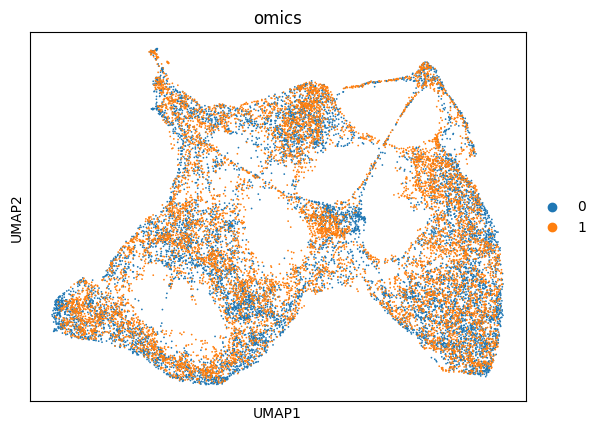

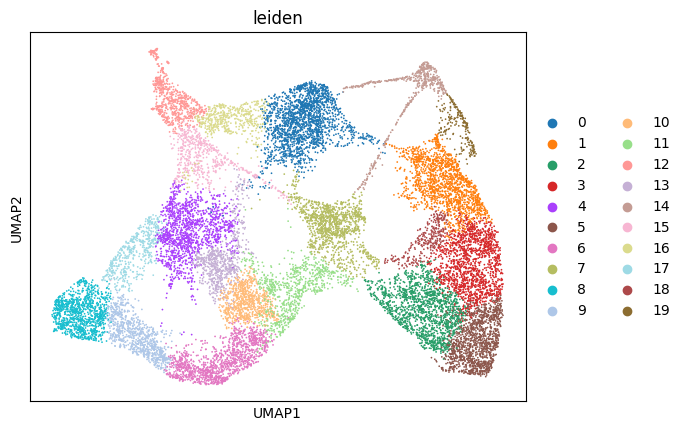

In [34]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="leiden")

In [35]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

In [36]:
def exchCoor(adata):
    spatial = pd.DataFrame(adata.obsm["spatial"])
    spatial.columns = ["x","y"]
    spatial["x"] = [-1*i for i in list(spatial["x"])]
    # spatial["y"] = [-1*i for i in list(spatial["y"])]

    new_spatial = np.array(spatial[["x","y"]])
    adata.obsm["spatial"] = new_spatial
exchCoor(t_rna)
exchCoor(t_atac)

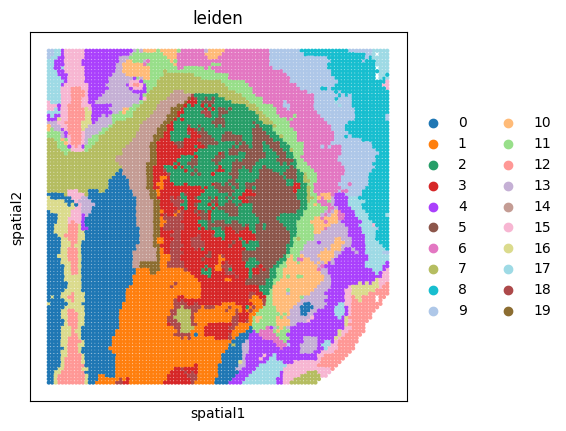

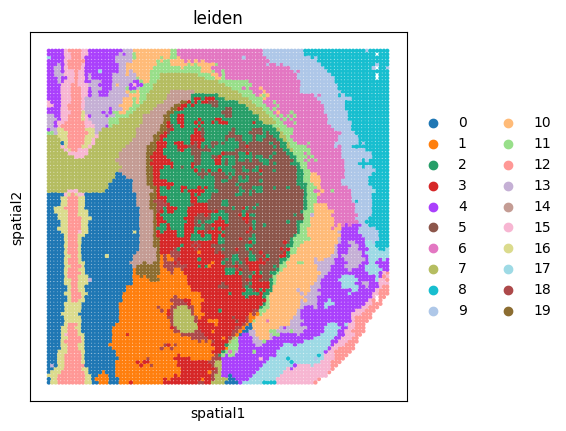

In [37]:
sc.pl.spatial(t_atac, color="leiden",spot_size=34)
sc.pl.spatial(t_rna, color="leiden",spot_size=34)

In [41]:
import scipy
def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
):
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    n1, _ = d.shape
    true_matching = np.arange(n1)
    mask = (d.T < d[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))
x=foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])
x

0.04297724483942649

In [ ]:
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# cluster = pd.DataFrame(combined.obs["leiden"])
# cluster.to_csv("rep1/SWITCH_cluster.csv")